# Counterfactual reasoning demo

In [1]:
import numpy as np
import pylab as pl
from numpy import sqrt, log
from scipy.stats import norm, uniform, laplace
from IPython.html.widgets import *


def bernstein(samples, delta, a, b):
    """Plug-n-chug empirical Bernstein bound, computes "error bars" which hold with
    probability `1-delta` for the mean of independent samples from a given range
    `b-a` (known a priori).

    Returns epsilon such that the following bound hold,

      p( mean(samples) - true_mean >= eps ) >= 1-delta

    We assume that sample are independent (not necessarily identically
    distributed).

    Bound is based on sample variance `V` and a priori knowledge that RVs in are
    in the range `[a,b]` (although we only really require a known range `b-a`)

    The bound holds with probability `>=(1-delta)`.

    The sample mean has symmetric deviations so we get a two-sided bound by
    passing in 2*delta, i.e.,

      p( |mean(samples) - true_mean| >= eps ) >= 1-2*delta

    This is analogous to p-values, which make assumption of normally distributed
    random variables. This means that the bounds can be 'tighter', but the
    assumptions are usually not valid.

    """
    n = len(samples)
    V = samples.var(ddof=1)   # sample variance
    #assert np.ptp(samples) <= b-a + 1e-8, [np.ptp(samples), b-a]
    return sqrt(V*2*log(2.0/delta)/n) + (b-a)*(7.0/3.0)*log(2.0/delta)/(n-1)


class bernstein_confidence:

    def __init__(self, L, p, Delta, R, M):
        """
        L: Logged data
           fs: Evaluations random variable (try to estimate E_{x ~ p}[ f(x) ])
           xs: samples from q.
           qs: proposal density

        p: target density

        R: upper bound on importance weights (used for clipping/capping)
        M: upper bound on objective.
        Delta: probability of failure in bound (the "confidence" of bound)
        """

        fs, samples, qs = L.fs, L.xs, L.qs

        w = p.pdf(samples) / qs

        # Using clipped weights eliminates the contribution of samples from poorly
        # explored regions -- a large weight indicates a mismatch between p and q.
        if 0:
            clip = w.copy()
            #clip[w > R] = 0.0                # zero-out large values
            clip[w > R] = R                # max-out large values

        else:
            # Smooth approximation to clip. This is result in a smoother
            # optimization problem, currently the objective function has a bunch of
            # kinks in it.
            #
            # check we satisfy the relevant assumptions (e.g., bounded by R).
            T = -5
            clip = np.logaddexp(R*T, w*T)/T
            #assert (clip <= R).all(), clip

        # Using these weights we obtain the following (biased) estimator
        yhat = (clip * fs).mean()

        # divide by three because final bound holds w.p.(1-3*delta), we have
        # 3*delta because we're using a two-sided bound and a one-sided bound.
        delta = Delta / 3.0

        # Solve for fudge terms of the two parts.
        eps_R = bernstein(clip * fs, 2*delta, 0, M*R)  # two-sided bound
        eta_R = bernstein(clip, delta, 0, R)           # one-sided bound

        inner_lb = yhat
        inner_ub = yhat + M*(1 - clip.mean() + eta_R)
        outer_lb = inner_lb - eps_R
        outer_ub = inner_ub + eps_R
        yhat     = yhat

        # use prior knowledge of ranges to keep estimate sane.
        self.inner_lb = np.clip(inner_lb, 0, M)
        self.inner_ub = np.clip(inner_ub, 0, M)
        self.outer_lb = np.clip(outer_lb, 0, M)
        self.outer_ub = np.clip(outer_ub, 0, M)
        self.yhat     = np.clip(yhat,     0, M)


class LoggedDataset(object):

    def __init__(self, fs, xs, qs):
        self.fs = fs
        self.xs = xs
        self.qs = qs

    def direct(self, p):
        "Ordinary importance sampling estimator for counterfactual expectation"
        w = p.pdf(self.xs) / self.qs
        return (self.fs*w).mean()

    def indirect(self, p, R=0):
        """
        Indirect importance sampling estimator for counterfactual expectation.

        R: importance weight penalty from Levine & Koltun (2013).
        """
        w = p.pdf(self.xs) / self.qs
        return (self.fs * w).sum() / w.sum() - R*np.log(w.sum())

    def bernstein(self, p, **kwargs):
        return bernstein_confidence(self, p, **kwargs)


class InteractivePlot(object):

    def __init__(self, hs, f, p):
        self.hs = hs
        self.f = f
        self.p = p

        # precompute true expectation because it doesn't change.
        def expect(h, dx=0.1):
            "Integration by quadrature"
            x = pl.arange(h-50, h+50, dx)
            return (p(h).pdf(x) * f(x) * dx).sum()

        self.expect = np.array([expect(h) for h in hs])

    def update(self, N, R, q_mu, q_sigma):
        # which things to plot.
        indirect = 0
        bottou = 1

        hs = self.hs
        p = self.p
        M = 1

        # Take a new sample.
        q = norm(q_mu, scale=q_sigma)
        samples = q.rvs(size=N)

        L = LoggedDataset(self.f(samples),
                          samples,
                          q.pdf(samples))

        # TODO: need to tune on held out data.
        #R = L.tune_R(hs, p, M, plot=1)

        A = np.array([L.direct(p(h)) for h in hs])

        if indirect:
            B = np.array([L.indirect(p(h), R=0) for h in hs])

        if bottou:
            ci = np.array([L.bernstein(p(h), Delta=0.1, R=R, M=M) for h in hs])
            ci_lb, yhat, ci_ub = np.array([(x.outer_lb, x.yhat, x.outer_ub) for x in ci]).T
            ci_inner_lb, ci_inner_ub = np.array([(x.inner_lb, x.inner_ub) for x in ci]).T

        pl.plot(hs, self.expect, c='k', alpha=1.0, lw=2, label='true')
        pl.plot(hs, A, c='r', alpha=0.75, lw=2, label='direct')

        if indirect:
            pl.plot(hs, B, c='orange', alpha=0.75, lw=2, label='indirect')

        if bottou:
            pl.plot(hs, ci_ub, c='b', alpha=0.5, label='upper')
            pl.plot(hs, yhat, c='b', alpha=0.5, lw=2, label='$clipped')
            pl.plot(hs, ci_lb, c='b', alpha=0.5, label='lower')
            pl.fill_between(hs, ci_inner_lb, ci_inner_ub, alpha=0.25, color='b')
            pl.plot(hs, ci_inner_lb, color='b')

        pl.title('Estimates')
        pl.ylim(-0.25, 1.5)
#        pl.legend(loc='best')

/home/timv/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Demo for a one-dimension problem

The problem setup is as follows

* $q$: normal distribution (you can play with the mean and standard deviation).
* $p$: normal distribution with standard deviation = 1 and mean determined by $\theta$.
* $r$: is a non-differentiable function (see definition in code or look at picture).

The following plot illustrates these components along with $J(\theta)$. 

Note that we're taking a "shortcut" to make a nice plot: we assume that $\mathcal{X}$ and $\theta$ live in the same space. This is clearly not always allowed, e.g., when $\mathcal{X}$ is discrete or when $\theta$ isn't the mean of a simple policy family.

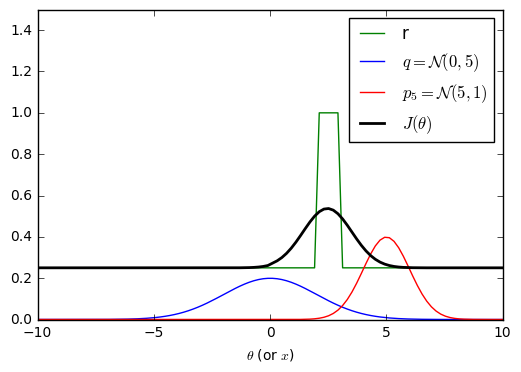

In [3]:
def p(h): return norm(h, scale=1.0)

def r(x):
    y = ((2 < x) & (x < 3)) + .25
    y[y > 1] = 1
    return y

hs = pl.linspace(-20, 20, 200)
pl.plot(hs, r(hs), label='r', c='g')
pl.plot(hs, norm(0, 2).pdf(hs), label='$q=\mathcal{N}(0,5)$', c='b')
pl.plot(hs, p(5).pdf(hs), label=r'$p_{5}=\mathcal{N}(5,1)$', c='r')
pl.plot(hs, InteractivePlot(hs, r, p).expect, label=r'$J(\theta)$', c='k', lw=2)
pl.legend(loc='best')
pl.xlabel(r'$\theta$ (or $x$)')
pl.ylim(0, 1.5)
pl.xlim(-10, 10);

## Interactive demo

Here you can play around with some of the components of the picture above.

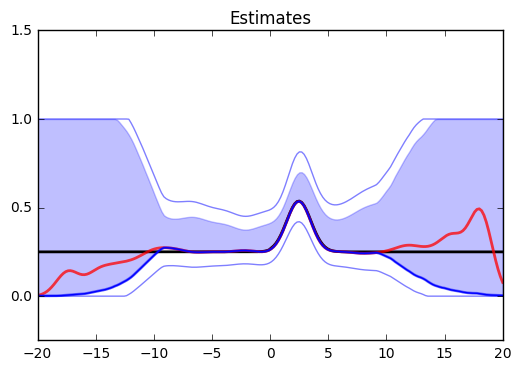

In [8]:
def p(h):
    return norm(h, scale=1.0)
#    return uniform(h, scale=1.0)
#    return laplace(h, scale=1.0)

objective = 3
if objective == 1:
    def r(x):
        y = 0.5*np.sin(x/2)*x
        y[y >= 1] = 1
        y[y <= 0] = 0
        return y
else:
    def r(x):
        y = ((2 < x) & (x < 3)) + .25
        y[y > 1] = 1
        return y

    
hs = pl.linspace(-20, 20, 200)
foo = InteractivePlot(hs, r, p)

interact(foo.update, N=(1, 5000, 50), R=(1, 100, 1), q_mu=(-10, 10, 1), q_sigma=(1, 10, 1));